# **Laboratorio 2 - Visión por Computadora**

- Paula Barillas - 22764
- Gerardo Pineda - 22880
- Mónica Salvatierra - 22249

Link del repositorio: https://github.com/paulabaal12/LAB2-VCP

## **Task 1**

In [52]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from skimage import io, filters, morphology

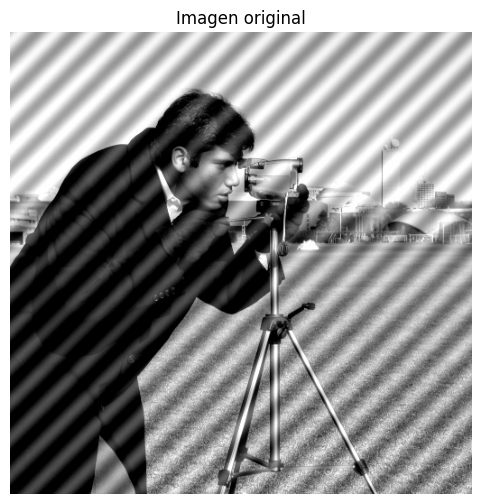

In [53]:
img = cv2.imread("img/periodic_noise.jpg", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No se encontró la imagen.")

plt.figure(figsize=(6,6))
plt.imshow(img, cmap="gray")
plt.title("Imagen original")
plt.axis("off")
plt.show()


### **DFT + desplazar componente DC al centro**

In [54]:
img_f = img.astype(np.float32)


F = np.fft.fft2(img_f)
Fshift = np.fft.fftshift(F)


### **Espectro de magnitud**

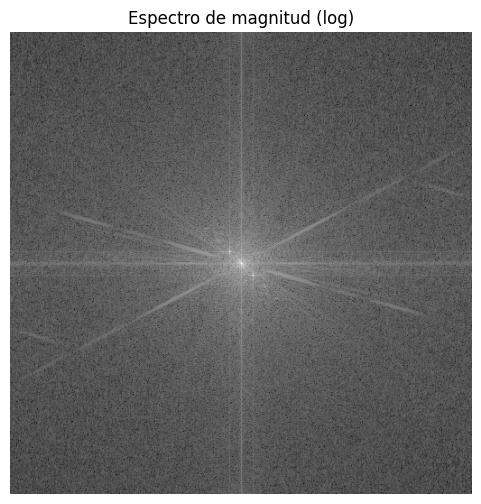

In [55]:

mag_log = np.log1p(np.abs(Fshift))

plt.figure(figsize=(6,6))
plt.imshow(mag_log, cmap="gray")
plt.title("Espectro de magnitud (log)")
plt.axis("off")
plt.show()



### **Picos de energía que no contribuyen a la información natural de la imagen**

In [56]:
h, w = mag_log.shape
cy, cx = h//2, w//2

safe = mag_log.copy()

# Quitar centro
Y, X = np.ogrid[:h, :w]
r0 = int(0.06 * min(h, w))
safe[(Y-cy)**2 + (X-cx)**2 <= r0**2] = 0

# Quitar cruz
band = 10
safe[:, cx-band:cx+band] = 0
safe[cy-band:cy+band, :] = 0

# Tomar 10 más brillantes
N = 10
flat_indices = np.argpartition(safe.ravel(), -N)[-N:]
coords = np.column_stack(np.unravel_index(flat_indices, safe.shape))

# Ordenar por intensidad
coords = sorted(coords, key=lambda c: safe[c[0], c[1]], reverse=True)

# Nos quedaremos con los 2 más fuertes
peaks = np.array(coords[:2])

print("Picos usados:", peaks)




Picos usados: [[230 230]
 [282 282]]


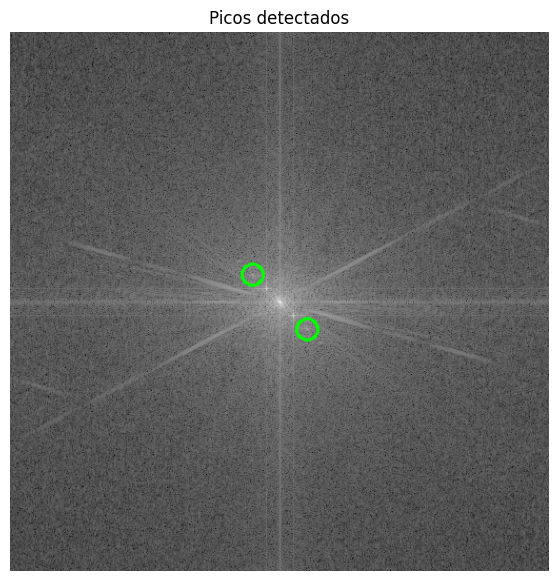

In [57]:
view = cv2.normalize(mag_log, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
view = cv2.cvtColor(view, cv2.COLOR_GRAY2BGR)

for py, px in peaks:
    cv2.circle(view, (px, py), 10, (0,255,0), 2)

plt.figure(figsize=(7,7))
plt.imshow(view[..., ::-1])
plt.title("Picos detectados")
plt.axis("off")
plt.show()



### **Máscara Notch Filter**
Bloqueamos específicamente los picos de frecuencia detectados, pero preservamos el componente DC.

In [58]:
H = np.ones((h, w), dtype=np.float32)
radius = 24

Y, X = np.ogrid[:h, :w]

for py, px in peaks:
    sy, sx = 2*cy - py, 2*cx - px

    H[(Y-py)**2 + (X-px)**2 <= radius**2] = 0
    H[(Y-sy)**2 + (X-sx)**2 <= radius**2] = 0



### **Aplicación Notch Filter e IDFT**

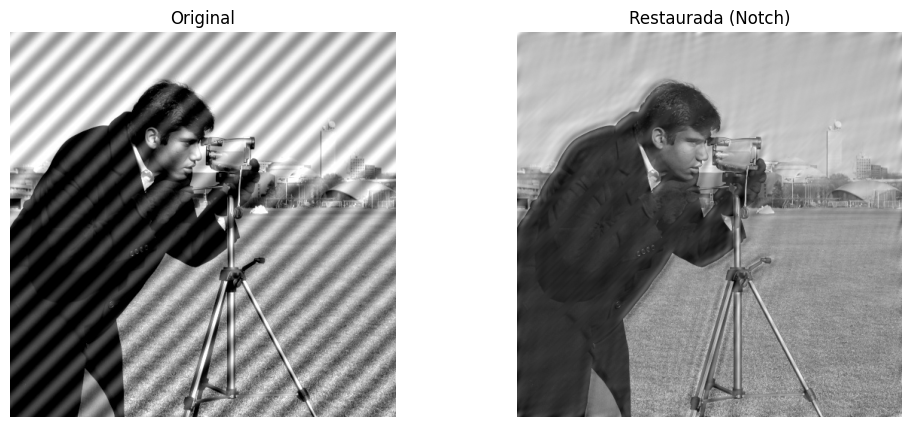

In [59]:
F_filtered = Fshift * H

img_back = np.fft.ifft2(np.fft.ifftshift(F_filtered))
img_back = np.real(img_back)

img_back = cv2.normalize(img_back, None, 0, 255, cv2.NORM_MINMAX)
img_back = img_back.astype(np.uint8)

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.imshow(img, cmap="gray")
plt.title("Original")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(img_back, cmap="gray")
plt.title("Restaurada (Notch)")
plt.axis("off")
plt.show()


### **Por qué un filtro de promedio (average filter) de 5x5 en el dominio espacial hibiera sido una mala solución para este problema específico.**

Consideramos que hubiera sido una mala solución debido a que nos se podría distiguir enter el ruido y los detalles, ya que basicamente los emparejaría y al querer promediarlo con cada píxel con sus vecinos solo estaría bajando un poco el contraste de las rayas diagonales sin eliminarlas. Debido a esto, estaría borrando los bordes o texturas, por ejemplo del trípode, la silueta de la persona o detalles del fondo se verían con menor calidad. 

Consideramos que sería como difuminar toda la foto con un desenfoque pequeño, ya que si se aumenta el tamaño del filtro para eliminar las rayas, en este caso se volvería más borrosa y los contornos se perderían. El filtro notch en frecuencia atacaría solo las frecuencias donde vive el ruido sinusoidal y deja casi intactos los detalles reales de la imagen donde hay mejor contraste evitando que haya saturación o que se omitan los detalles.


## **Task 2**

In [38]:
img = io.imread("img/fingerprint_noisy.png")

Nos aseguramos que la imagen sea binaria 

In [39]:
t = filters.threshold_otsu(img)
bin_img = img > t 

Elección de operaciones morfológicas

In [40]:
# Apertura para quitar puntitos blancos 
selem_open = morphology.disk(1)  

# Cierre para conectar grietas pequeñas en crestas
selem_close = morphology.disk(2) 

# eliminar ruido blanco 
step2 = morphology.opening(bin_img, selem_open)

# conectar grietas
final_img = morphology.closing(step2, selem_close)


Mostrar operación original

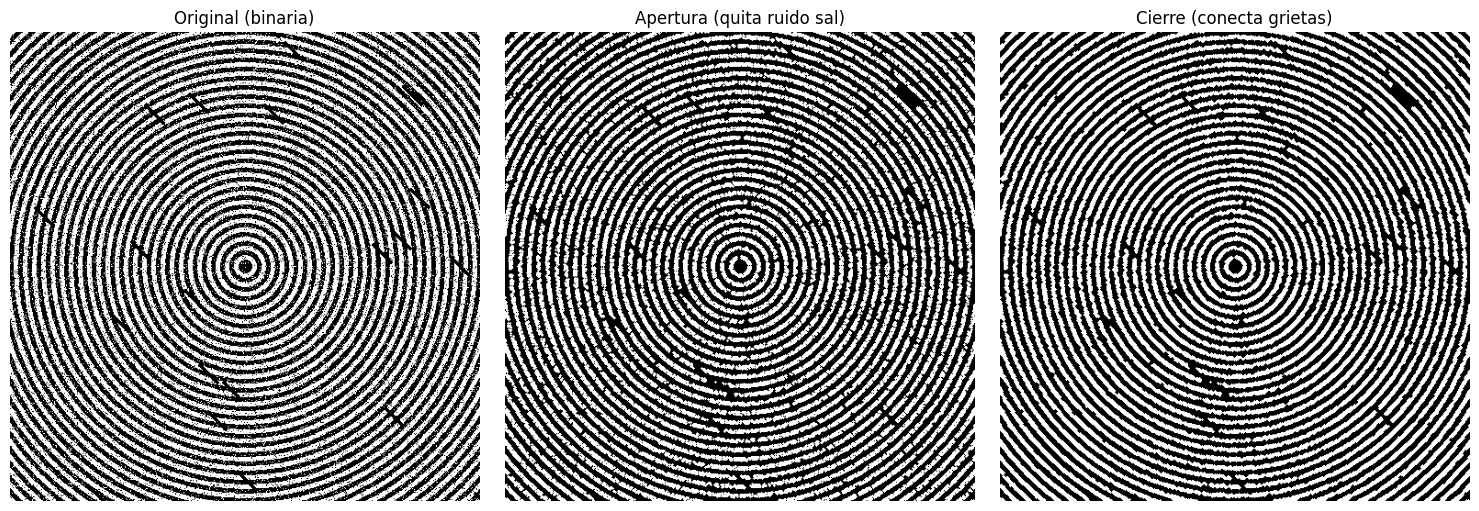

In [41]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(bin_img, cmap="gray")
ax[0].set_title("Original (binaria)")
ax[0].axis("off")

ax[1].imshow(step2, cmap="gray")
ax[1].set_title("Apertura (quita ruido sal)")
ax[1].axis("off")

ax[2].imshow(final_img, cmap="gray")
ax[2].set_title("Cierre (conecta grietas)")
ax[2].axis("off")

plt.tight_layout()
plt.show()

Mostrar operación inversa

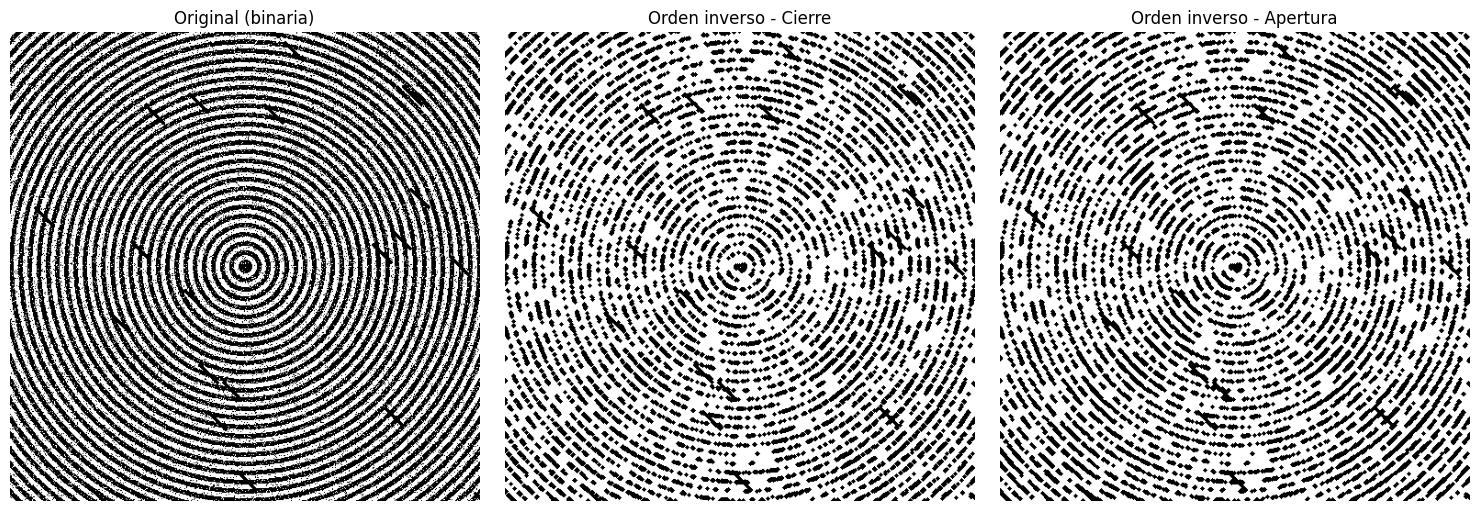

In [42]:
inv_step2 = morphology.closing(bin_img, selem_close)
inv_final = morphology.opening(inv_step2, selem_open)

fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].imshow(bin_img, cmap="gray")
ax[0].set_title("Original (binaria)")
ax[0].axis("off")

ax[1].imshow(inv_step2, cmap="gray")
ax[1].set_title("Orden inverso - Cierre")
ax[1].axis("off")

ax[2].imshow(inv_final, cmap="gray")
ax[2].set_title("Orden inverso - Apertura")
ax[2].axis("off")

plt.tight_layout()
plt.show()


**¿El orden de los factores altera el producto? Explique qué hubiera pasado si hubiera
aplicado las operaciones en orden inverso y demuéstrelo con un ejemplo visual en el notebook.**

- El orden de las operaciones morfólogicas alteran el resultado final. En este caso, las operaciones de apertura y cierre no son conmutativas, por lo que el resultado se ve afectando por el orden en el que se aplican (tal como se observa en las imagenes generadas arriba).

    En el caso de la primera fila, la apertura sirve para eliminar el ruido sal, sin afectar de manera significativa la estructura de las crestas. Posteriormente, el cierre rellena las grietas y conecta discontinuidades en las crestas, de tal manera que pueda generar una imagen mucho más limpia.

    Por otro lado, en la segunda fila se observa que en el cierre, se engrosan un poco las crestas e integra cierto ruido blanco a la estructura principal. Luego, la apertura eliminar detalles finos o romper conexiones delgadas que el cierre acababa de formar, generando una imagen más fragmentada y menos uniforme.

    El orden inverso produce una textura más discontinua y menos limpia que el orden correcto. Por lo tanto, el orden de aplicación sí influye directamente en la calidad del resultado final.

## **Task 3**

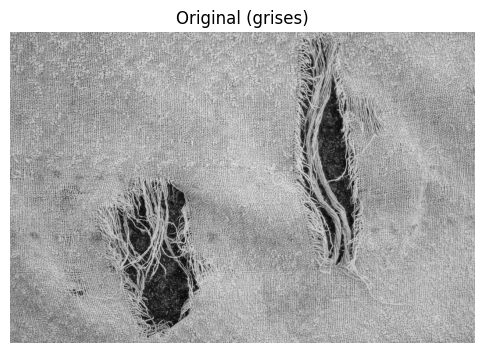

In [60]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def show(img, title="", cmap="gray"):
    plt.figure(figsize=(6,6))
    plt.imshow(img, cmap=cmap)
    plt.title(title)
    plt.axis("off")
    plt.show()

img = cv2.imread("img/image.png", cv2.IMREAD_GRAYSCALE)
if img is None:
    raise FileNotFoundError("No pude leer la imagen. Revisa PATH.")

img_f = img.astype(np.float32) / 255.0
show(img, "Original (grises)")


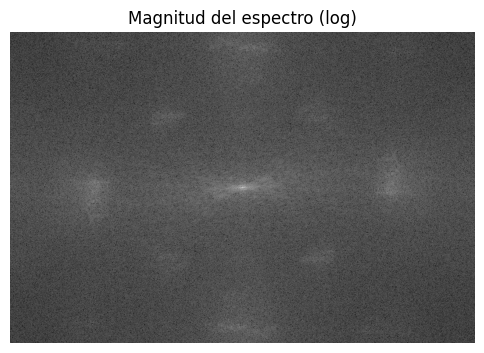

In [44]:
#FFT
F = np.fft.fft2(img_f)
Fshift = np.fft.fftshift(F)
mag = np.log1p(np.abs(Fshift))

show(mag, "Magnitud del espectro (log)")


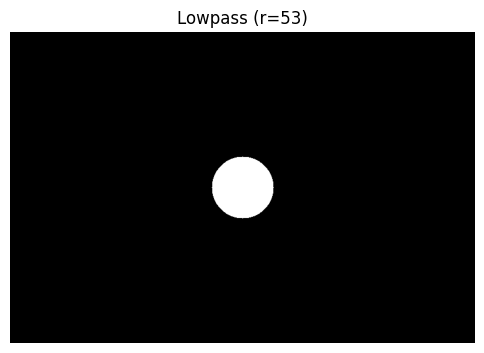

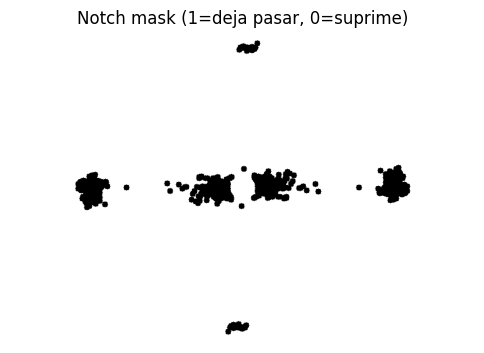

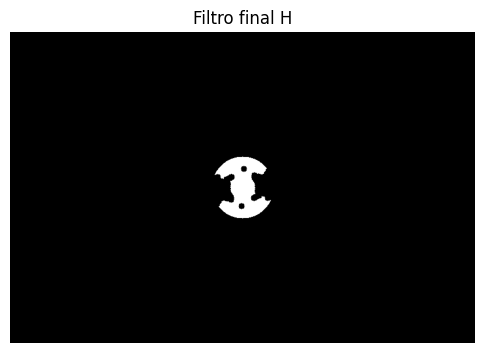

In [45]:
# FFT
h, w = img.shape
cy, cx = h // 2, w // 2
Y, X = np.ogrid[:h, :w]
dist2 = (Y - cy) ** 2 + (X - cx) ** 2

r = int(0.10 * min(h, w)) 
lowpass = (dist2 <= r * r).astype(np.float32)

use_notch = True
notch = np.ones((h, w), np.float32)

if use_notch:
    center_exclusion = int(0.05 * min(h, w))
    safe = mag.copy()
    safe[dist2 < center_exclusion**2] = 0

    thr = np.percentile(safe, 99.7)       
    peaks = np.argwhere(safe > thr)
    notch_radius = max(3, int(0.01 * min(h, w)))

    for (py, px) in peaks:
        cv2.circle(notch, (int(px), int(py)), notch_radius, 0, -1)
        sy = int(2 * cy - py)
        sx = int(2 * cx - px)
        if 0 <= sy < h and 0 <= sx < w:
            cv2.circle(notch, (sx, sy), notch_radius, 0, -1)

H = lowpass * notch

show(lowpass, f"Lowpass (r={r})")
show(notch, "Notch mask (1=deja pasar, 0=suprime)")
show(H, "Filtro final H")


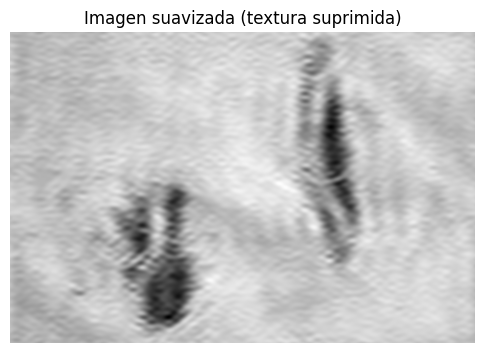

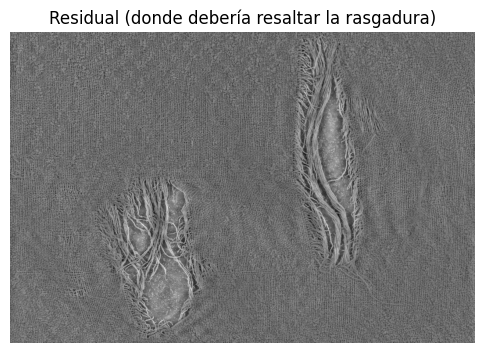

In [46]:
#Threshold 
F_filt = Fshift * H
img_smooth = np.fft.ifft2(np.fft.ifftshift(F_filt))
img_smooth = np.real(img_smooth)

img_smooth = (img_smooth - img_smooth.min()) / (img_smooth.max() - img_smooth.min() + 1e-9)

residual = img_f - img_smooth
residual = (residual - residual.min()) / (residual.max() - residual.min() + 1e-9)

show(img_smooth, "Imagen suavizada (textura suprimida)")
show(residual, "Residual (donde debería resaltar la rasgadura)")


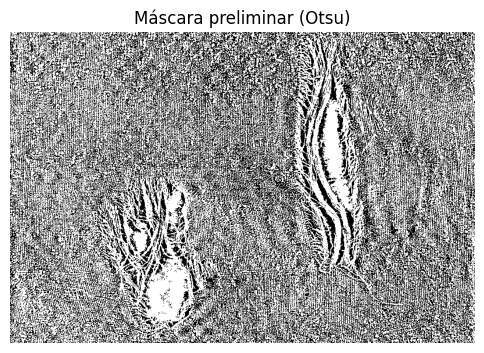

In [47]:
res8 = (residual * 255).astype(np.uint8)

invert = False

if not invert:
    _, mask0 = cv2.threshold(res8, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
else:
    _, mask0 = cv2.threshold(res8, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

show(mask0, "Máscara preliminar (Otsu)")


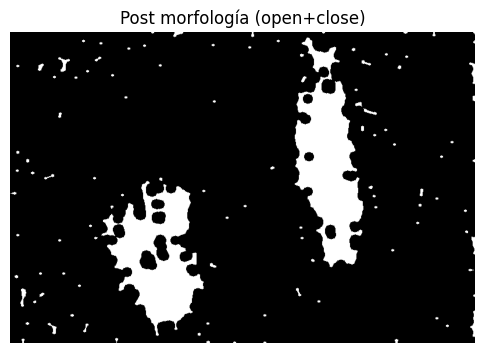

In [48]:
k1 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
k2 = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (9, 9))

mask = cv2.morphologyEx(mask0, cv2.MORPH_OPEN, k1, iterations=1)
mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, k2, iterations=2)

show(mask, "Post morfología (open+close)")


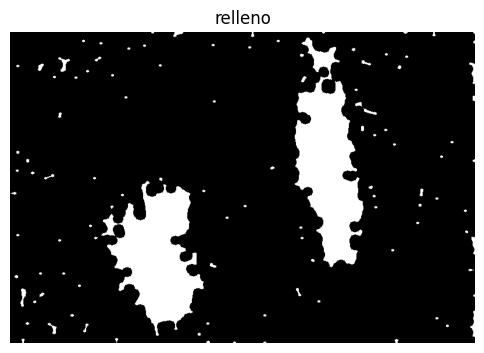

In [49]:
# Fill holes
flood = mask.copy()
h2, w2 = mask.shape
cv2.floodFill(flood, np.zeros((h2 + 2, w2 + 2), np.uint8), (0, 0), 255)
holes = cv2.bitwise_not(flood)
mask_filled = cv2.bitwise_or(mask, holes)

show(mask_filled, "relleno")

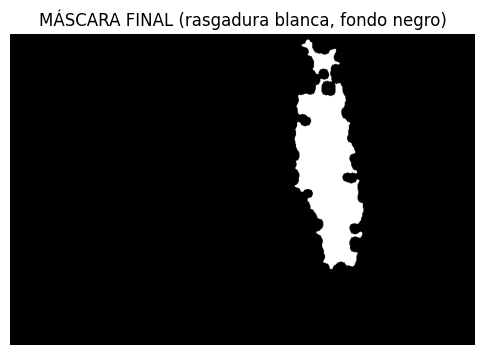

In [50]:
# Componente conectado más grande
num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(mask_filled, connectivity=8)
if num_labels > 1:
    largest = 1 + np.argmax(stats[1:, cv2.CC_STAT_AREA])
    final_mask = np.where(labels == largest, 255, 0).astype(np.uint8)
else:
    final_mask = mask_filled

show(final_mask, "MÁSCARA FINAL (rasgadura blanca, fondo negro)")

Uno de los trade off se encuentran al usar la frecuencia para quitar la textura de la tela, esta funciona cuando la parte rasgada es clara y relativamente grande, porque resalta. Pero, si la rasgadura es muy pequeña o muy delgada, puede perderse (como se mira en el ejercicio, que la rasgadura mas grande se quedo y la pequeña se quito), ya que el filtrado y la suavización también eliminan detalles finos. Si se llegara a cambiar el tipo de tela, que tenga patrones o textura, el filtro puede que no funcione igual y puede pasar que aparezca mas ruido, por eso no es muy confible la solución y no funcionaría en cualquier imagen.

## **Prompt Utilizado**

**Uso de ChatGPT**

**Task 1**
Para la primera tarea le pedimos a ChatGPT que nos guiara para eliminar el ruido periódico  sin perder los detalles geográficos. El modelo explicó cómo interpretar el espectro de magnitud y detectar los picos brillantes simétricos que corresponden al ruido. 

**Task 2**
En la segunda tarea le preguntamos cómo diseñar una secuencia de operaciones morfológicas para limpiar una huella binaria con ruido sal y grietas en las crestas. ChatGPT nos recomendó usar primero una apertura con un elemento estructurante pequeño para eliminar los puntos blancos en los valles sin destruir las crestas. 

**Task 3**
Para la tercera tarea le pedimos ayuda para interpretar el espectro de Fourier de una tela con textura fuerte y una rasgadura y orientació para diseñar un pipeline híbrido Fourier + morfología. El modelo explicó cómo usar un filtro en frecuencia para suprimir la textura periódica de la mezclilla y dejar una imagen suavizada donde resalta la rasgadura, luego aplicar un umbral. 

### Por qué funcionó este prompt
Los prompts funcionaron bien porque siempre proporcionamos el contexto de cada task, además de mencionar las restricciones del problema como el no perder detalles geográficos y que conserve las crestas de la huella, o bien separar la rasgadura de la textura de la tela. Se nos propuso un esqueleto lo suficientemente básico, que fuimos adapatando cada quién, según el contexto del problema a resolver.